In [1]:
!pip install uproot awkward lmfit
import uproot, scipy, math, os, random, time, pickle, collections
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import awkward as ak
from tqdm import tqdm
import pandas as pd
from scipy import stats
from scipy.spatial.distance import cdist
from google.colab import drive
from lmfit.models import GaussianModel
drive.mount('/content/drive', force_remount=True)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.7/330.7 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 596.2/596.2 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 35.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.4/98.4 kB 5.2 MB/s eta 0:00:00
Mounted at /content/drive


In [2]:
f_data = uproot.open('/content/drive/MyDrive/data/ForAli/match2.root')

data = f_data['trackParam'].arrays(['fitParam_x',
                                    'fitParam_y',
                                    'fitParam_z',
                                    'fitParam_px',
                                    'fitParam_py',
                                    'fitParam_pz',
                                    'fitParam_chi2',
                                    'fitParam_charge',
                                    'fitParam_nMeasurements',
                                    'fitParam_align_id',
                                    'fitParam_align_local_residual_x'], library='ak') 

In [3]:
f_mc = uproot.open('/content/drive/MyDrive/data/alignment/r0013/kfalignment_data_iter32.root')

mc = f_mc['trackParam'].arrays(['fitParam_x',
                                'fitParam_y',
                                'fitParam_z',
                                'fitParam_px',
                                'fitParam_py',
                                'fitParam_pz',
                                'fitParam_chi2',
                                'fitParam_charge',
                                'fitParam_nMeasurements',
                                'fitParam_align_unbiased_sp',
                                'fitParam_align_stationId_sp',
                                'fitParam_align_layerId_sp',
                                'fitParam_align_local_residual_x_sp'], library='ak')  

In [4]:
# Set up plot defaults 
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = 11.0,8.0  # Roughly 11 cm wde by 8 cm high
mpl.rcParams['font.size'] = 12.0 # Use 12 point font

## Check the Performance of Residual x in IFT

In [5]:
def cut(data, Station, charge, pzmin, pzmax):
    cut = ak.where((ak.flatten(data['fitParam_chi2']) < 100)&
                (ak.flatten(data['fitParam_charge']) == charge)&
                (ak.flatten(data['fitParam_pz']) >= pzmin*1e3)&
                (ak.flatten(data['fitParam_pz']) < pzmax*1e3)&
                (ak.flatten(data['fitParam_nMeasurements']) > 14))
    
    res_x = ak.flatten(ak.flatten(data['fitParam_align_local_residual_x'])[cut])
    id = ak.flatten(ak.flatten(data['fitParam_align_id'])[cut])
    station=(id//1000)%10
    layer=(id//100)%10
    module=(id//10)%10

    return res_x[ak.where(station==Station)]

def cut_ke(data, Station, charge, pzmin, pzmax):
    cut = ak.where((ak.flatten(data['fitParam_chi2']) < 100)&
                (ak.flatten(data['fitParam_charge']) == charge)&
                (ak.flatten(data['fitParam_pz']) >= pzmin*1e3)&
                (ak.flatten(data['fitParam_pz']) < pzmax*1e3)&
                (ak.flatten(data['fitParam_nMeasurements']) > 14))
    
    res_x = ak.flatten(ak.flatten(data['fitParam_align_local_residual_x_sp'])[cut])
    station=ak.flatten(ak.flatten(data['fitParam_align_stationId_sp'])[cut])
    layer=ak.flatten(ak.flatten(data['fitParam_align_layerId_sp'])[cut])

    return res_x[ak.where(station==Station)]

def gaussfun(data):
    bin=np.linspace(-0.05, 0.05, 26)
    npix = len(data)
    nbins = int(np.sqrt(npix))
    #data = np.random.standard_normal(npix)
    n, bins = np.histogram(data, bins=nbins, density=True)
    n, bins = np.array(n), np.array(bins)

    # Generate data from bins as a set of points 
    bin_size = abs(bins[1]-bins[0])
    x =np.linspace(start=bins[0]+bin_size/2.0,stop=bins[-2]+bin_size/2.0, num=nbins,endpoint=True)
    y = n

    model = GaussianModel()
    params = model.guess(y, x=x)
    result = model.fit(y, params, x=x)
    return bin, x, result

def getmusig(result):
    round_num = 5
    mu_tmp = round(result.params['center'].value, round_num)
    mu_err_tmp = round(result.params['center'].stderr, round_num)
    std_tmp = round(result.params['sigma'].value, round_num)
    std_err_tmp = round(result.params['sigma'].stderr, round_num)

    return mu_tmp, mu_err_tmp, std_tmp, std_err_tmp

    #return result.params['center'].value, result.params['center'].stderr, result.params['sigma'].value, result.params['sigma'].stderr

color=['steelblue', 'orange', 'green']

def Plot(TS, station, charge, label, pz1, pz2, mc=True):
    # Generate data from random Guassian distribution
    if mc: 
        data = cut_ke(TS, station, charge, pz1, pz2)
    else: 
        data = cut(TS, station, charge, pz1, pz2)
    data = data[ak.where((data>-0.06)&(data<0.06))]

    bin, x, result = gaussfun(data)
    mu, mu_err, std, std_err = getmusig(result)

    plt.xlabel('Residual x (mm)', fontsize=20)
    plt.hist(data, bins=bin, histtype='step', linewidth=0.5, density=True, alpha=0.6)
    plt.plot(x, result.best_fit, linewidth=2, label=f'{label} µ: {mu}±{mu_err}, σ:{std}±{std_err}')
    
    plt.ylabel('Number of Events (normalized)', fontsize=20)
    plt.xticks(fontsize=20)
    plt.legend(fontsize=15)
    plt.xlim(-0.06, 0.06)
    
    plt.title(f'station{station}, charge{charge}, pz=[{pz1}, {pz2}]GeV', fontsize=20)

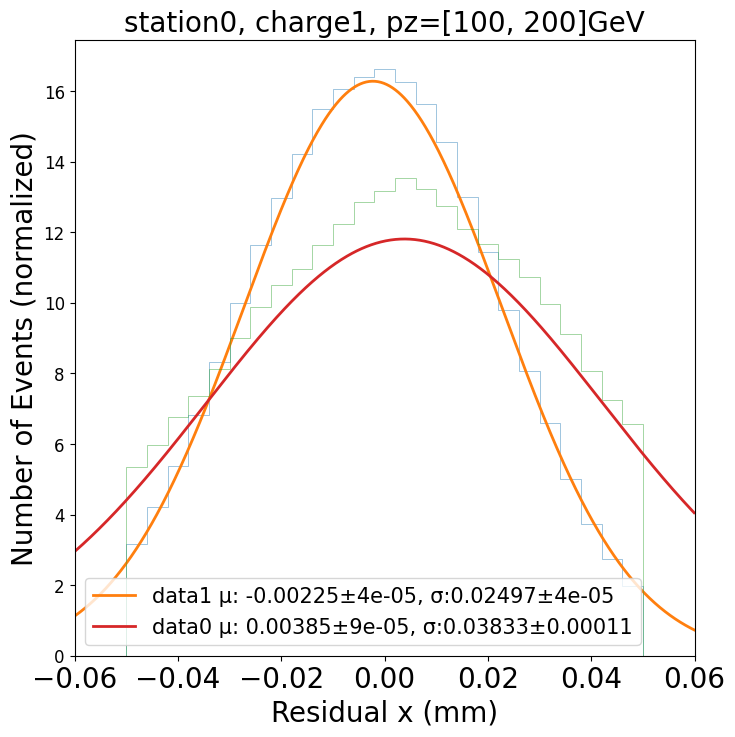

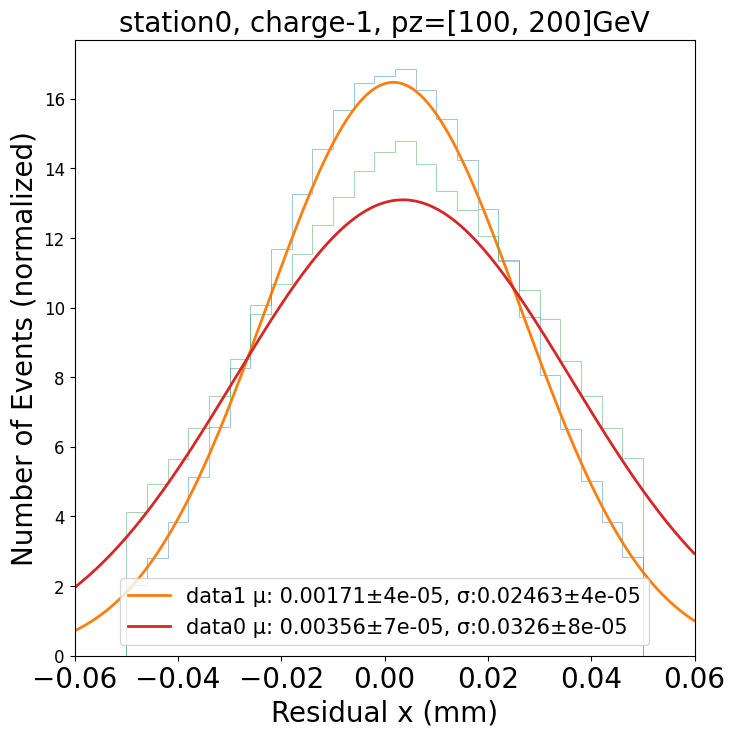

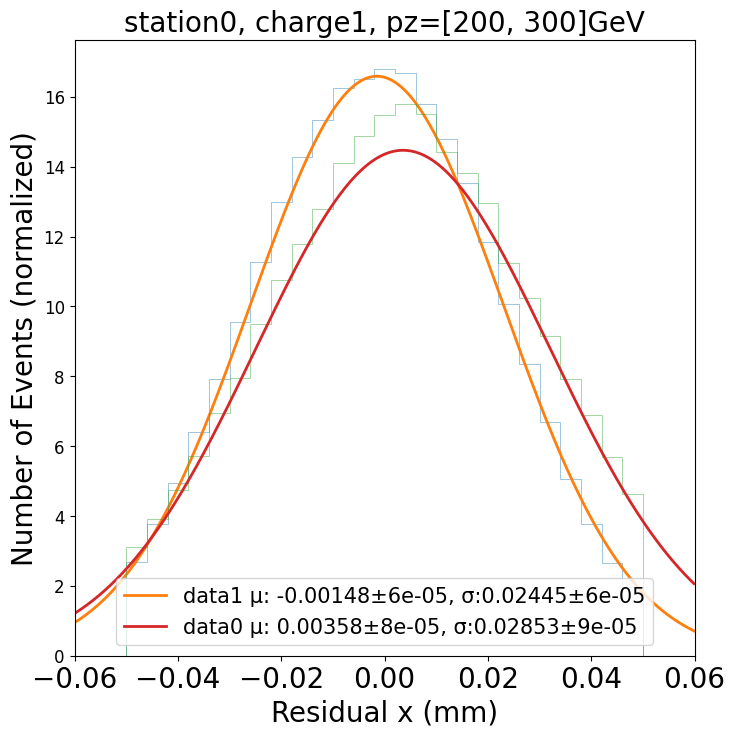

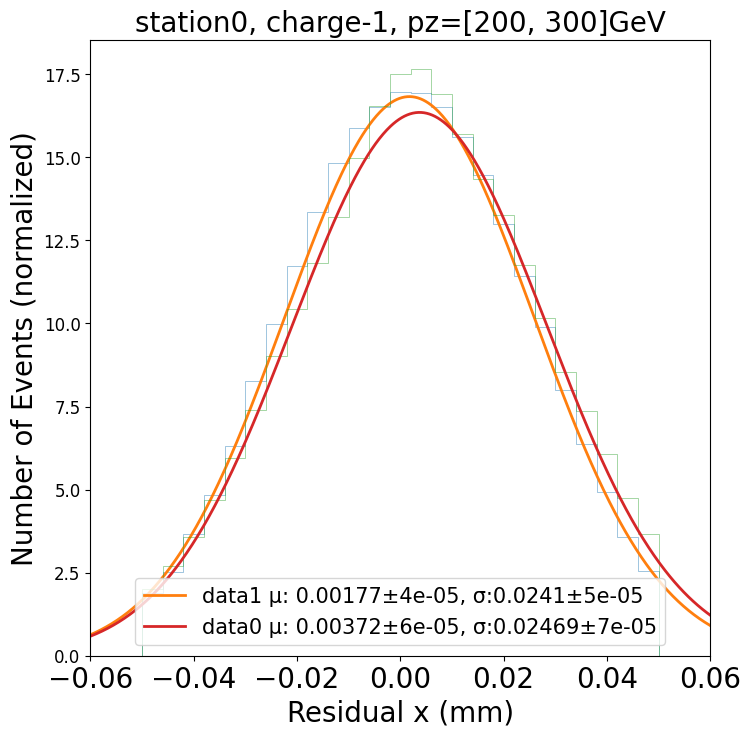

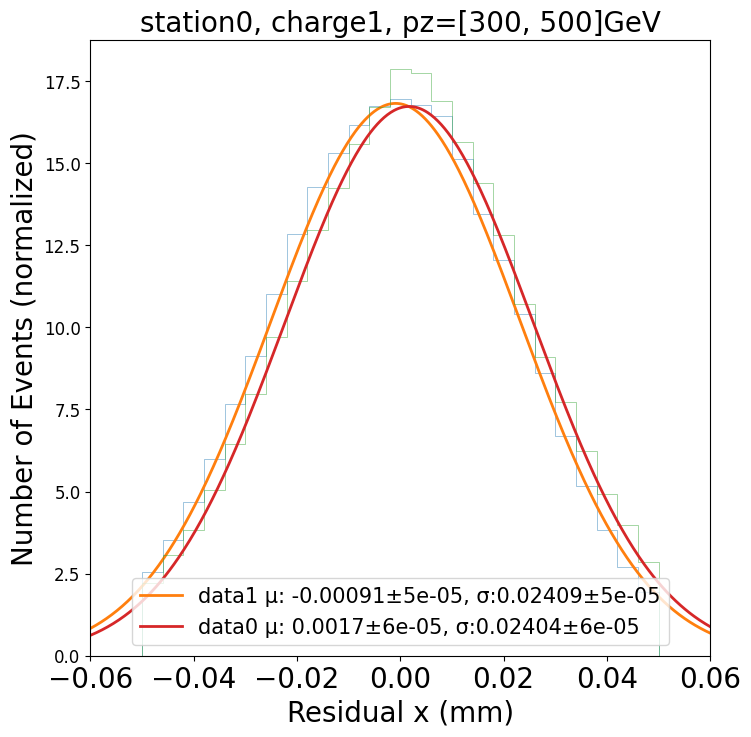

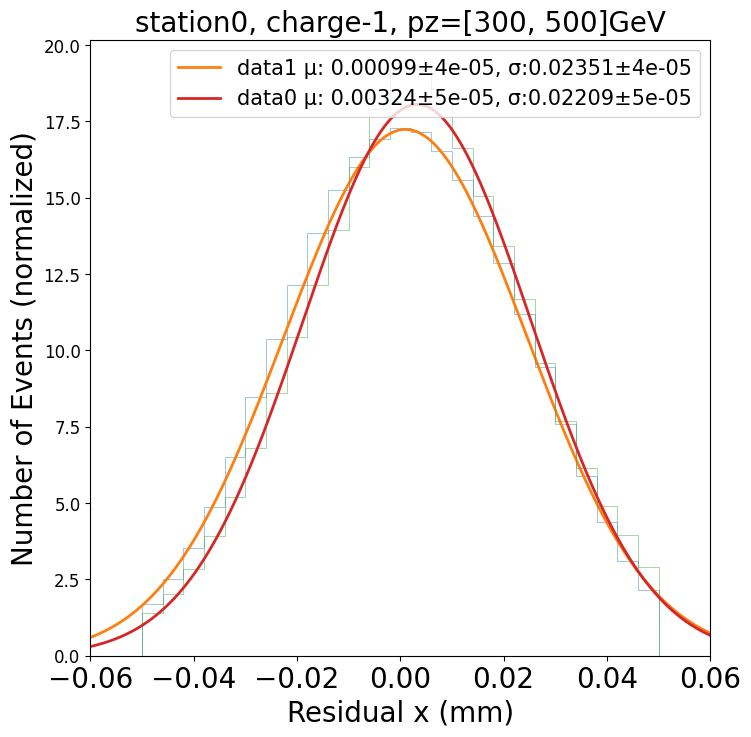

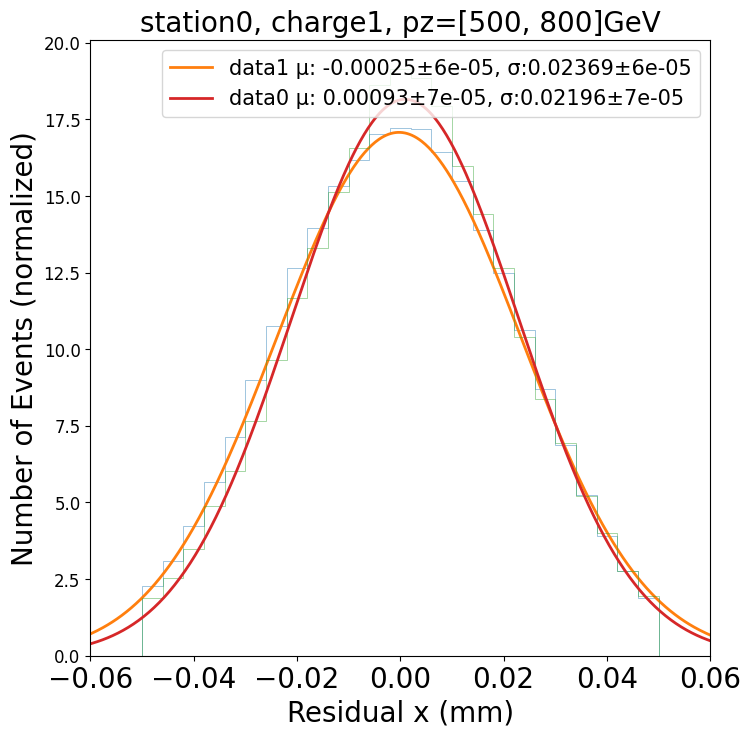

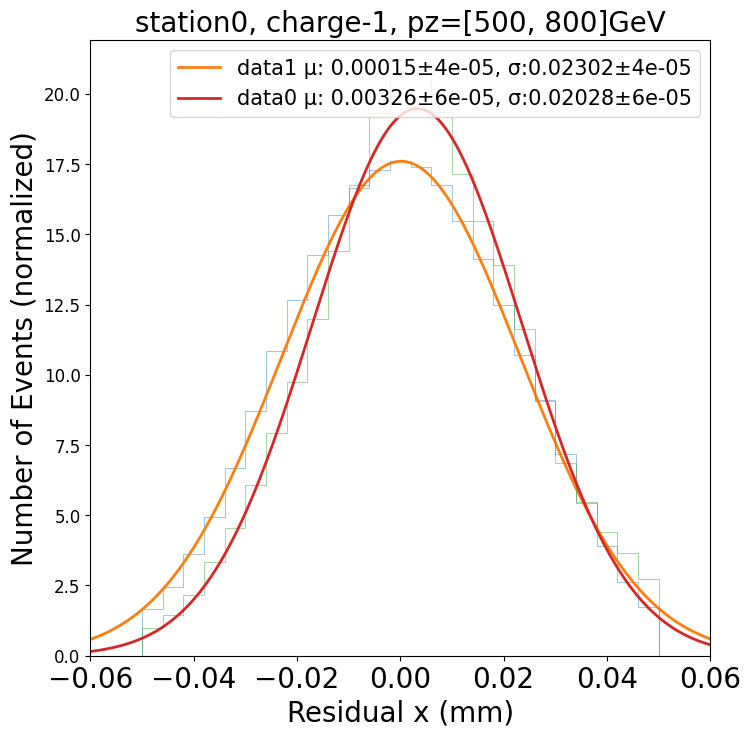

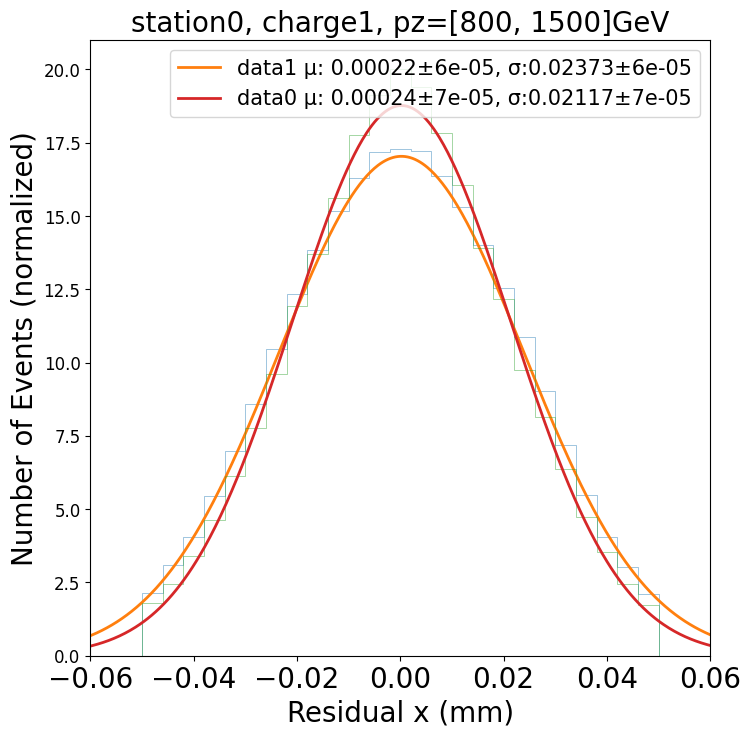

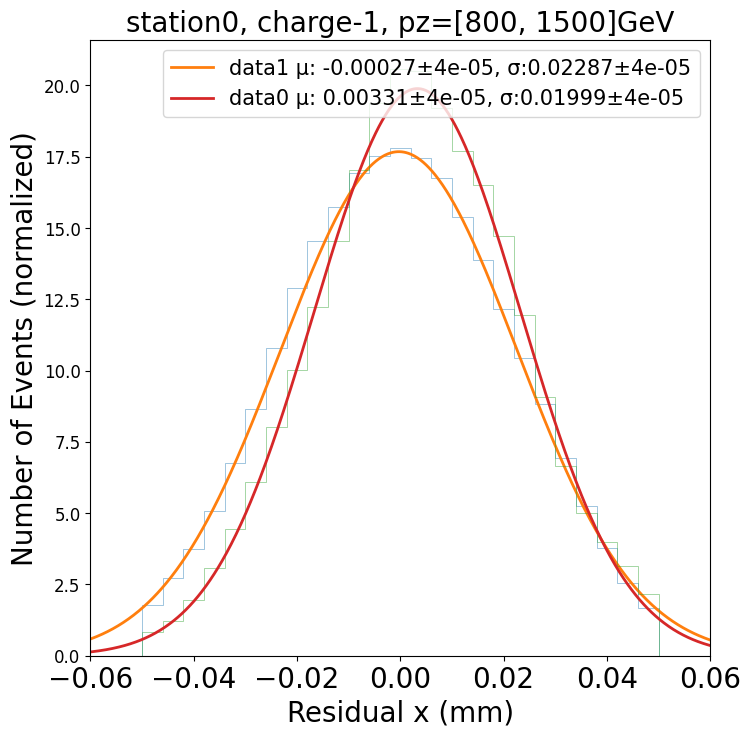

In [6]:
ptmp = [100, 200, 300, 500, 800, 1500]
sta = 0
for i in range(len(ptmp)-1):
    fig = plt.figure(figsize=(8, 8))
    Pz1, Pz2 = ptmp[i], ptmp[i+1]
    Plot(data, 1, 1, 'data1', Pz1, Pz2, mc=False)
    Plot(data, 0, 1, 'data0', Pz1, Pz2, mc=False)

    #Plot(mc, 1, 1, 'mc', Pz1, Pz2, mc=True)

    fig = plt.figure(figsize=(8, 8))
    Plot(data, 1, -1, 'data1', Pz1, Pz2, mc=False)
    Plot(data, 0, -1, 'data0', Pz1, Pz2, mc=False)

    #Plot(mc, 1, -1, 'mc', Pz1, Pz2, mc=True)

## Pz distribution: Pz cut should > 200 GeV

In [7]:
def Hist(title, xlabel, ylabel, show=True):
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    if show:
        plt.show()

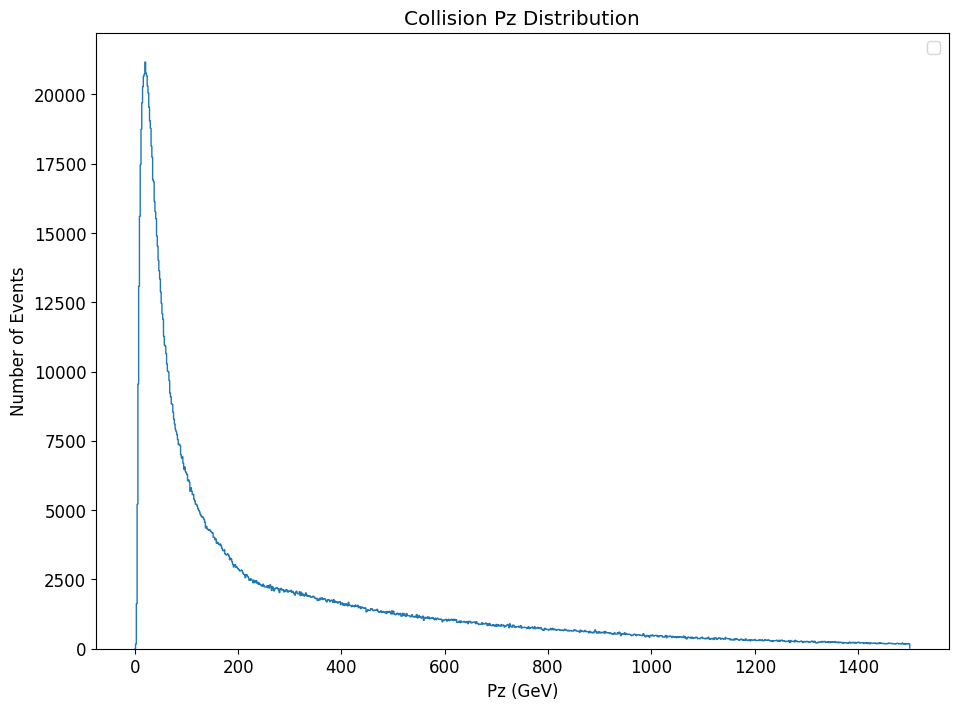

In [8]:
plt.hist(data['fitParam_pz']/1e3, histtype='step', bins=np.linspace(0, 1500, 1000))  # momentum is in MeV 
Hist('Collision Pz Distribution', 'Pz (GeV)', 'Number of Events')

## tx Distribution: Prove that x-flip issue is fixed

In [9]:
def tx_cut(charge):
    cut = ak.where(
        (ak.flatten(data['fitParam_charge'])==charge)&
        #(ak.num(data['fitParam_x'])==1)&
        (ak.flatten(data['fitParam_x'])**2 + ak.flatten(data['fitParam_y'])**2 < 100**2))
    
    return ak.flatten(data['fitParam_px']/data['fitParam_pz'])[cut]

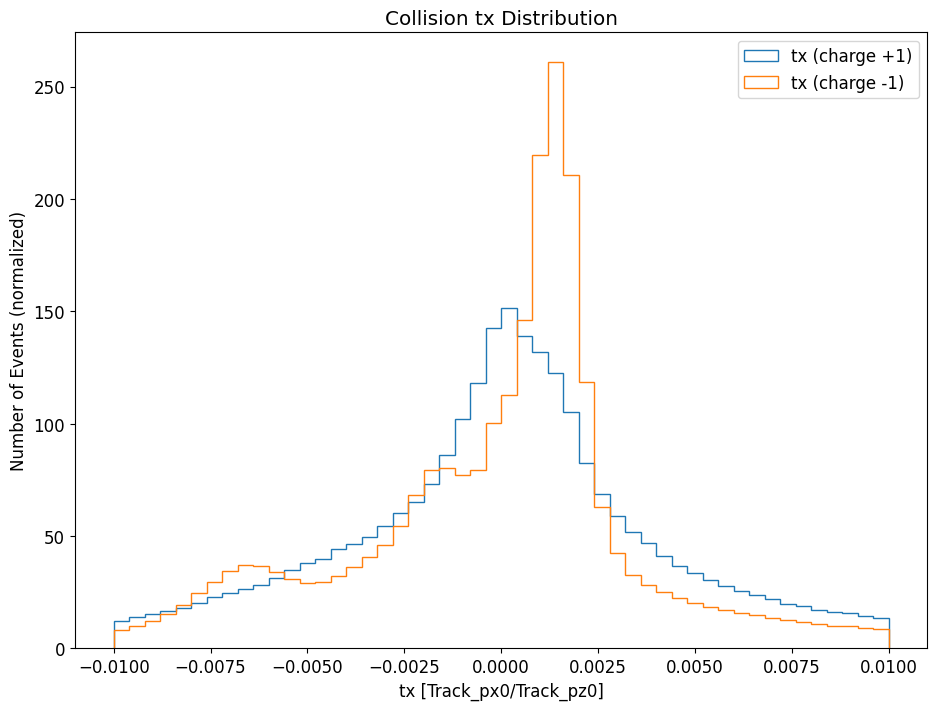

In [10]:
plt.hist(tx_cut(1), histtype='step', density=True, bins=np.linspace(-0.01, 0.01, 51), label='tx (charge +1)')
plt.hist(tx_cut(-1), histtype='step', density=True, bins=np.linspace(-0.01, 0.01, 51), label='tx (charge -1)')
Hist('Collision tx Distribution', 'tx [Track_px0/Track_pz0]', 'Number of Events (normalized)')

## Track_z0 Distribution: Track_z0 cut should < -1880 mm

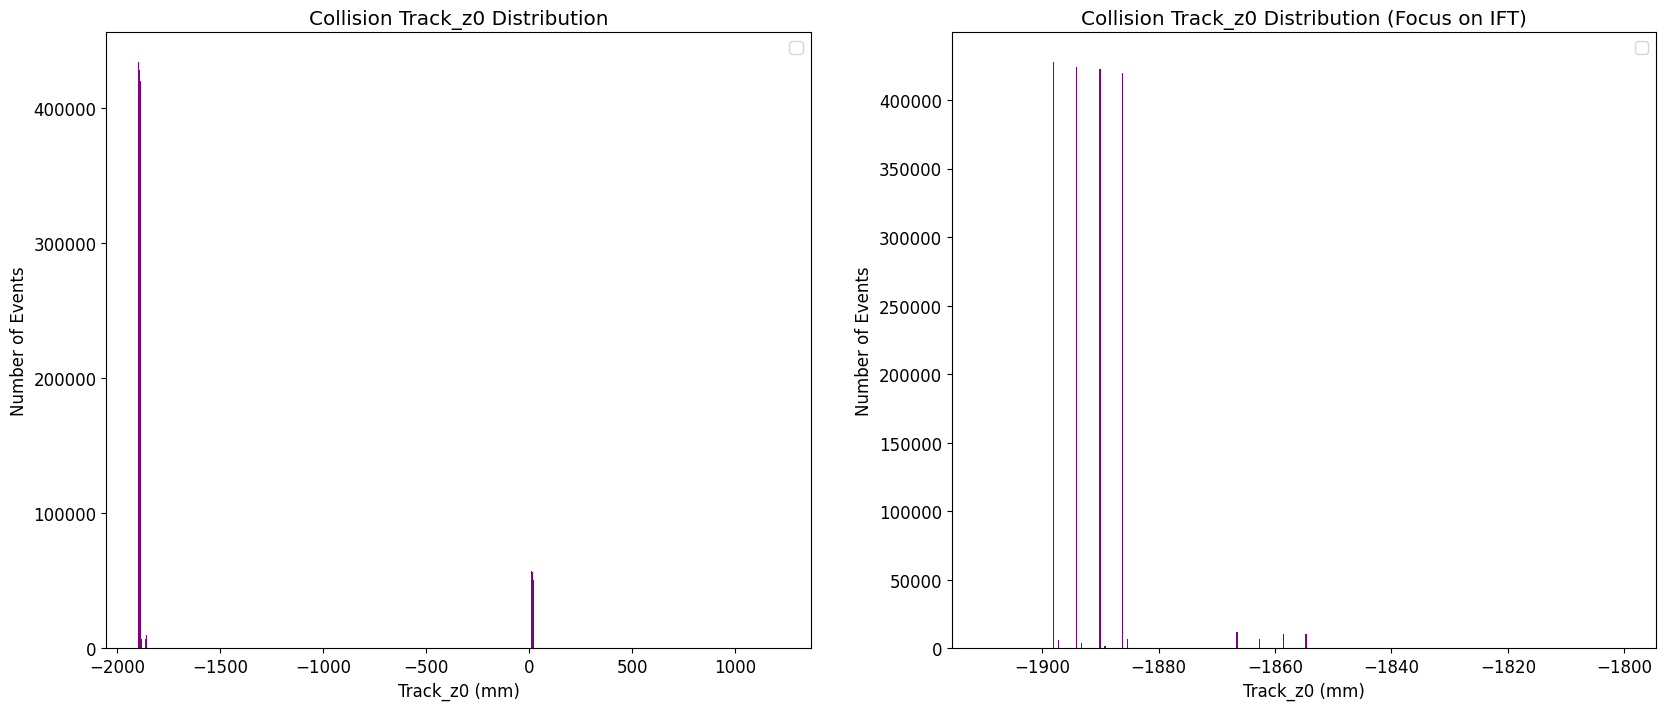

In [11]:
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.hist(data['fitParam_z'], color='purple', bins=1001)
Hist('Collision Track_z0 Distribution', 'Track_z0 (mm)', 'Number of Events', show=False)

plt.subplot(1, 2, 2)
plt.hist(data['fitParam_z'], color='purple', bins=np.linspace(-1910, -1800, 511))
Hist('Collision Track_z0 Distribution (Focus on IFT)', 'Track_z0 (mm)', 'Number of Events')

## Chi2 Distribution: Chi2 cut should < 100

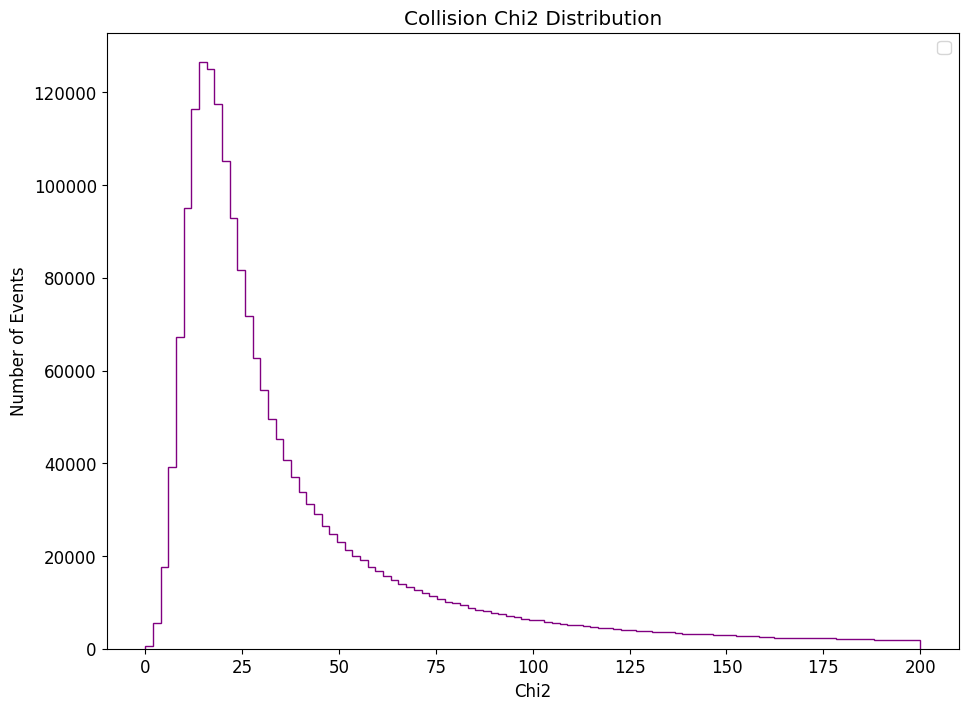

In [12]:
plt.hist(data['fitParam_chi2'], histtype='step', color='purple', bins=101)
Hist('Collision Chi2 Distribution', 'Chi2', 'Number of Events', show=True)

## Relative position between Emulsion and IFT w/ respect to nominal LoS

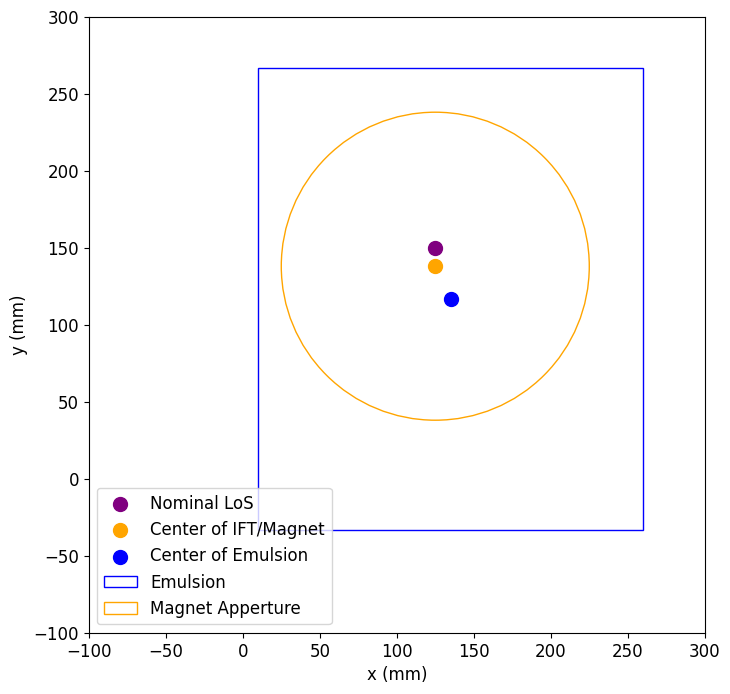

In [26]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle

# create figure and axis objects
fig, ax = plt.subplots()

# plot points
ax.scatter(125, 150, c='purple', s=100, label='Nominal LoS')
ax.scatter(125, 138, c='orange', s=100, label='Center of IFT/Magnet')
ax.scatter(135, 117, c='blue', s=100, label='Center of Emulsion')

# plot rectangle
rect = Rectangle((135 - 125, 117 - 150), 250, 300, edgecolor='blue', facecolor='none', label='Emulsion')
ax.add_patch(rect)

# plot circle
circle = Circle((125, 138), 100, edgecolor='orange', facecolor='none', label='Magnet Apperture')
ax.add_patch(circle)

# set axis limits and aspect ratio
ax.set_xlim([-100, 300])
ax.set_ylim([-100, 300])
ax.set_aspect('equal')
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')

# show plot
plt.legend()
plt.show()
